# Bert fine-tuning

## Go emotions

It's a classification task dataset made of 58k reddit comments.
Goemotions is a very unique dataset because quite often emotion classification task follows the directive to classify within only 6 emotions (which are very often joy, anger, fear, sadness, disgust, and surprise) proposed by Ekman in 1992 while goemotions classify the entries in 27 emotions + 1 neutral.<br>
What follows is based on the official goemotion paper analysis for fine tuning bert.

### Data preparation
The twitter dataset is full of biases and is very toxic so we will take the already prepared data got from the paper work, which provide for example:
1. Reducing profanity
2. Sentiment balancing
3. Subreddit balancing
4. Length filtering
5. mask proper names referring to people with a [NAME] token and religion terms with a [RELIGION] token.


To minimize the noise in our data, we filter out emotion labels selected by only a single annotator. We keep examples with at least one label after this filtering is performed—this amounts to 93% of the original data. We randomly split this data into train (80%), dev (10%) and test (10%) sets.

In [73]:

import numpy as np
from bs4 import BeautifulSoup
import emoji
import pandas as pd
import time
import datetime
import gc
import random
import string
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from lib.dataset_utils import *
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lib import dataset_utils
import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [2]:
# conversione dataset in 6 emozioni + neutral


In [44]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
label_names = train_df.columns[1:]
label_names

Index(['admiration', 'amusement', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'anger', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment'],
      dtype='object')

Di seguito si mappano i dataset con la ekman:
1. prima dalla hot encoding si genera una hot encoding mappata 
poi si droppato le colonne extra

In [45]:
def _or(dataset, array):
    value = dataset[array.pop(0)]
    for column in array:
        value = value | dataset[column]
    return value 

def map_to_Ekman(dataset):
    dataset["_joy"] = _or(dataset,  ["admiration", "amusement", "approval", "caring","desire", "excitement", "gratitude", "joy", "love", "optimism", "pride", "relief"])
    dataset["_anger"] = _or(dataset, ["anger","annoyance", "disapproval"])
    dataset["_surprise"] = _or(dataset, ["confusion", "curiosity", "realization", "surprise"])
    dataset["_sadness"] = _or(dataset, ["disappointment", "embarrassment", "grief", "remorse", "sadness"])
    dataset["_disgust"] = dataset["disgust"]
    dataset["_fear"] = _or(dataset, ["fear","nervousness"])
    dataset["_neutral"] = dataset["neutral"]

map_to_Ekman(train_df)
map_to_Ekman(val_df)
map_to_Ekman(test_df)

In [46]:
train_df = train_df.drop(columns=['admiration', 'amusement', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'anger', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment'])
val_df=val_df.drop(columns=['admiration', 'amusement', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'anger', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment'])
test_df =test_df.drop(columns=['admiration', 'amusement', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'anger', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment'])

In [6]:
train_df

,text,_joy,_anger,_surprise,_sadness,_disgust,_fear,_neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,1,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,1,0
4,Dirty Southern Wankers,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,1,0,0,0,0,0,0
43406,Always thought that was funny but is it a refe...,0,0,1,0,0,0,0
43407,What are you talking about? Anything bad that ...,0,1,0,0,0,0,0
43408,"More like a baptism, with sexy results!",1,0,0,0,0,0,0


In [47]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

train_df['text'] = train_df['text'].apply(text_preprocessing_pipeline)
val_df['text'] = val_df['text'].apply(text_preprocessing_pipeline)

'''
train_df = train_df.drop(columns=['_neutral'])
val_df = val_df.drop(columns=['_neutral'])
test_df = test_df.drop(columns=['_neutral'])


# Removing samples with only 0 in their labels
train_df = train_df.loc[ train_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]
val_df = val_df.loc[ val_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]
test_df = test_df.loc[ test_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]
'''   



C:\Users\gdema\AppData\Local\Temp\ipykernel_11040\3554187402.py:51: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


"\ntrain_df = train_df.drop(columns=['_neutral'])\nval_df = val_df.drop(columns=['_neutral'])\ntest_df = test_df.drop(columns=['_neutral'])\n\n\n# Removing samples with only 0 in their labels\ntrain_df = train_df.loc[ train_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]\nval_df = val_df.loc[ val_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]\ntest_df = test_df.loc[ test_df.apply(lambda x: sum(x[1:]), axis=1)>0 ]\n"

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
device

device(type='cuda', index=0)

In [49]:
#We utilize the uncased version of Bert where both HELLO and Hello will be tokenized as hello
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [50]:
train_df.sum(axis=0)

text         my favorite food is anything i did not have to...
_joy                                                     17410
_anger                                                    5579
_surprise                                                 5367
_sadness                                                  3263
_disgust                                                   793
_fear                                                      726
_neutral                                                 14219
dtype: object

In [51]:
df=train_df
tr_text=np.asarray(df["text"])
#prima c'era un as_array
tr_labels =df.drop(columns=["text"])
tr_labels=torch.tensor(tr_labels.values, dtype=torch.float32)

In [52]:
print(' Original: ', tr_text[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tr_text[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tr_text[0])))

 Original:  my favorite food is anything i did not have to cook myself
Tokenized:  ['my', 'favorite', 'food', 'is', 'anything', 'i', 'did', 'not', 'have', 'to', 'cook', 'myself']
Token IDs:  [2026, 5440, 2833, 2003, 2505, 1045, 2106, 2025, 2031, 2000, 5660, 2870]


In [16]:
max_len = 77
temp=[]
tempL =[]
max=0
# For every sentence...
#rimuoviamo tutte le entry di lunghezza maggiore di 47 => outliers
for i in range(len(tr_text)):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tr_text[i], add_special_tokens=True)
    if len(input_ids) > max:
        max= len(input_ids)
    if len(input_ids) <= max_len:
        temp.append(tr_text[i])
        tempL.append(tr_labels[i])
        
tr_text=np.asarray(temp)
tr_labels=torch.stack(tempL)
print(max)

77


In [53]:
input_ids = []
attention_masks = []
token_type_ids = []

# For every tweet...
for text in tr_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text,      
                        truncation=True,               # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)

# Print sentence 0, now as a list of IDs.
print('Original: ', tr_text[0])
print('Token IDs:', input_ids[0])
print('mask:', attention_masks[0])
print('Token type IDs:', token_type_ids[0])

c:\Users\gdema\Anaconda3\envs\Hlt\Lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  my favorite food is anything i did not have to cook myself
Token IDs: tensor([ 101, 2026, 5440, 2833, 2003, 2505, 1045, 2106, 2025, 2031, 2000, 5660,
        2870,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])
Token type IDs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


In [54]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks,token_type_ids, tr_labels)

print('{:>5,} training samples'.format(len(train_dataset)))


43,410 training samples


In [77]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# 16 for the paper
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


In [78]:

#overridiamo la classe di bert per modificare la funzione di loss e altri hyperparametri del modello
from transformers import BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class BertMultiLabelClassifier(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(BertMultiLabelClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768,7)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        probabilities = self.sigmoid(logits)
        return probabilities

In [65]:
train_dataset[0]

(tensor([ 101, 2026, 5440, 2833, 2003, 2505, 1045, 2106, 2025, 2031, 2000, 5660,
         2870,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
 tensor([0., 0., 0., 0., 0., 0., 1.]))

In [79]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
# TODO: provare dropout di 1
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=27, problem_type="multi_label_classification" )
model = BertMultiLabelClassifier()
# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()

model = model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [80]:
optimizer = torch.optim.AdamW(model.parameters(),weight_decay=1e-6,
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                )

### Fine-tuning

In [81]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4


In [82]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [70]:
"""
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
"""

'\nseed_val = 42\nrandom.seed(seed_val)\nnp.random.seed(seed_val)\ntorch.manual_seed(seed_val)\ntorch.cuda.manual_seed_all(seed_val)\n'

In [83]:
torch.cuda.empty_cache()

In [84]:
loss=0
training_stats = []
import gc

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[3].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             attention_mask=b_input_mask)
        
        loss=nn.BCELoss()
        loss = loss(output,b_labels.float())
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # TODO:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        del b_input_ids
        del b_input_mask
        del b_labels
        gc.collect()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    torch.save(model, 'bert-emotionsClassification'+str(epoch_i+1))

print("")
print("Training complete!")


print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.25
  Training epoch took: 0:09:13

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.19
  Training epoch took: 0:09:18

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.14
  Training epoch took: 0:08:51

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.09
  Training epoch took: 0:09:16

Training complete!
Total training took 0:36:39 (h:mm:ss)


In [85]:
train_df.sum(axis=0)

text         my favorite food is anything i did not have to...
_joy                                                     17410
_anger                                                    5579
_surprise                                                 5367
_sadness                                                  3263
_disgust                                                   793
_fear                                                      726
_neutral                                                 14219
dtype: object

## Test

In [86]:
# Model evaluation function 
from sklearn.metrics import precision_recall_fscore_support
def model_eval(y_true, y_pred_labels, emotions):
    
    # Defining variables
    precision = []
    recall = []
    f1 = []
    
    # Per emotion evaluation      
    idx2emotion = {i: e for i, e in enumerate(emotions)}
    
    for i in range(len(emotions)):
   
        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")
        
        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))
    
    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")
    
    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))
    
    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']
    
    return df_results

In [88]:
#loading the best model
from sklearn.metrics import f1_score
import torchvision.models as models

model = torch.load('bert-emotionsClassification4')
val_text = np.asarray(test_df["text"])
val_labels =test_df.drop(columns=["text"])
val_labels=torch.tensor(val_labels.values, dtype=torch.float32)

max_len = 0

# For every sentence...
for text in val_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    val_ids = tokenizer.encode(text, add_special_tokens=True)

    if len(val_ids) > max_len:
        max_len=len(val_ids)

print('Max sentence length: ', max_len)

val_ids = []
attention_masks = []

# For every tweet...
for text in val_text:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 55,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    val_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
val_ids = torch.cat(val_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
val_labels = torch.tensor(val_labels,dtype=torch.long)

# Combine the training inputs into a TensorDataset.
val_dataset = TensorDataset(val_ids, attention_masks)

print('{:>5,} training samples'.format(len(val_dataset)))

batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
val_dataloader = DataLoader(
            val_dataset,  # The training samples.
            sampler = RandomSampler(val_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

model.eval()
predictions = torch.tensor([])
predictions=predictions.to(device)
with torch.no_grad():  
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        output= model(b_input_ids, 
                            attention_mask=b_input_mask)
        logits = output        
        predictions = torch.cat((predictions,torch.tensor(output)),dim=0)
        logits = logits.detach().cpu().numpy()

predictions_=predictions.cpu()

newPred=np.where( predictions_>= 0.2, 1,0)
print("f1-score = "+str(f1_score(val_labels,newPred,average="macro")))

model_eval(val_labels,newPred,[ '_disgust', '_joy','_surprise', '_anger', '_sadness', '_fear',"_neutral"])

Max sentence length:  55


c:\Users\gdema\Anaconda3\envs\Hlt\Lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\gdema\AppData\Local\Temp\ipykernel_11040\285723566.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels,dtype=torch.long)
C:\Users\gdema\AppData\Local\Temp\ipykernel_11040\285723566.py:74: UserWarning: To copy construct from a tensor, it is recommended to use so

5,427 training samples
f1-score = 0.17290707707272587


,Precision,Recall,F1
_disgust,0.39,0.43,0.41
_joy,0.14,0.24,0.18
_surprise,0.12,0.14,0.13
_anger,0.07,0.08,0.08
_sadness,0.02,0.03,0.03
_fear,0.02,0.02,0.02
_neutral,0.33,0.43,0.38
MACRO-AVERAGE,0.16,0.20,0.17


In [93]:
newPred=np.where( predictions_>= 0.1, 1,0)
print("f1-score = "+str(f1_score(val_labels,newPred,average="macro")))

model_eval(val_labels,newPred,[ '_disgust', '_joy','_surprise', '_anger', '_sadness', '_fear',"_neutral"])

f1-score = 0.1829584089409832


,Precision,Recall,F1
_disgust,0.39,0.46,0.42
_joy,0.14,0.29,0.19
_surprise,0.11,0.18,0.14
_anger,0.07,0.09,0.08
_sadness,0.03,0.06,0.04
_fear,0.01,0.02,0.02
_neutral,0.33,0.50,0.40
MACRO-AVERAGE,0.16,0.23,0.18


Dato che stiamo facendo test non ha senso rimuovere entry con lunghezza maggiore di 47, si fa padding alla lunghezza dell'entry di lunghezza massima del test set (rispettando i limiti di BERT ( 512))

In [174]:
#verifichiamo con cross validation per f1-score il miglior threshold per determinare quando viene classificata o meno un emozione

In [175]:
def applyThreshold(x,threshold):
    if x>= threshold:
        return 1
    return 0
from sklearn.metrics import f1_score
results=[]
newPred=np.where( predictions_>= 0.3, 1,0)
results.append( f1_score(val_labels,newPred,average="macro"))


In [176]:
newPred[30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

Text(0.5, 0, 'threshold')

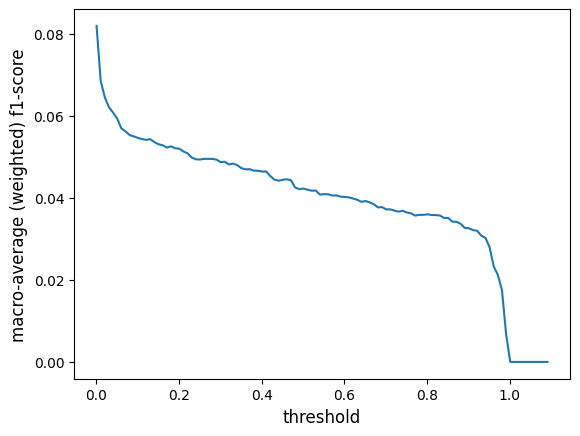

In [177]:
plt.plot(np.arange(0.001,1.1,0.01),results)
plt.ylabel("macro-average (weighted) f1-score",size=12)
plt.xlabel("threshold",size=12)

In [178]:
newPred=np.where( predictions_>= 0.3, 1,0)
f1_score(val_labels,newPred,average="macro")

0.04225295622185826

[]

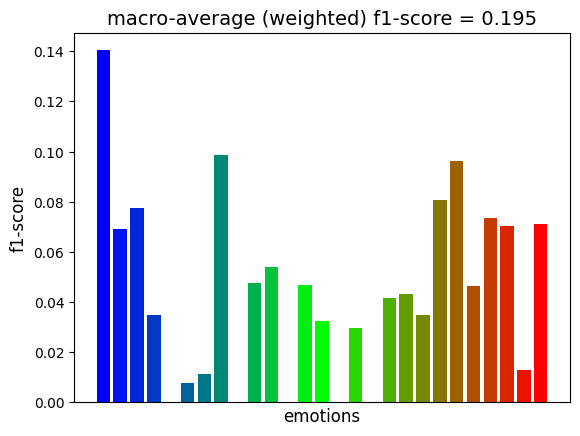

In [115]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#0000ff',"#00FF00" ,'#ff0000'])

figure, axs = plt.subplots(1)
axs.bar(range(len(a)),a,color=cmap(np.linspace(0, 1, len(a))))
axs.set_ylabel("f1-score",size=12)
axs.set_title("macro-average (weighted) f1-score = 0.195",size=14)
axs.set_xlabel("emotions",size=12)
axs.set_xticks([])


In [132]:
label_names=label_names.remove

Index(['admiration', 'amusement', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'anger', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment'],
      dtype='object')